<a href="https://colab.research.google.com/github/PatilVaishnav131/disease-prediction-ai/blob/main/Malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Certainly! Here's a comprehensive summary and description of the entire malaria detection pipeline you performed using the NIH dataset on Google Colab, from data preparation to model fine-tuning and evaluation:

## **Steps Performed in the Malaria Detection Pipeline**

### 1. **Data Preparation**
- **Downloading & Unzipping Dataset:**  
  Used the NIH malaria cell images dataset containing ~27,558 images labeled into two classes:  
  - `Parasitized`  
  - `Uninfected`

- **Organizing Dataset Structure:**  
  The original folder contained an unwanted extra folder (`cell_images` inside the dataset). You removed or excluded that folder so only the two class folders remained under the main data directory:  
  ```
  /content/MalariaDataset/cell_images/
      Parasitized/
      Uninfected/
  ```

- **Splitting Dataset:**  
  Created an explicit **train/validation/test split** by copying images into separate folders for each split and class, ensuring no data leakage:  
  ```
  /content/MalariaDataset/split/
      train/
          Parasitized/
          Uninfected/
      val/
          Parasitized/
          Uninfected/
      test/
          Parasitized/
          Uninfected/
  ```
  Split ratio example: 70% train, 15% validation, 15% test. Randomized images per class to ensure good distribution.

### 2. **Data Loading and Augmentation**
- Used Keras `ImageDataGenerator` to create data pipelines for training, validation, and test sets:

  - **Training Generator:**  
    Image preprocessing and augmentations such as rotation, zoom, shear, shift, and horizontal flipping along with rescaling pixel values to .

  - **Validation and Test Generators:**  
    Only rescaled pixel values without augmentation. Set `shuffle=False` for validation and test to preserve label order for evaluation accuracy.

- Verified that the data generators correctly detected the two classes and the image counts per split.

### 3. **Model Building**
- Initialized **MobileNetV2** (pretrained on ImageNet) as a base model with `include_top=False` to remove the classification head.

- Frozen the base model initially to prevent convolutional layers from training during initial epochs.

- Added custom classification layers on top:
  - Global Average Pooling layer
  - Dense layer with 128 neurons and ReLU activation
  - Dropout layer (0.3 rate)
  - Final Dense layer with 1 neuron and sigmoid activation for binary classification

- Compiled the model with `adam` optimizer, `binary_crossentropy` loss, and `accuracy` metric.

### 4. **Model Training**
- Trained the model on the training data with validation monitoring and used:
  - EarlyStopping callback to stop training on no validation loss improvement.
  - ModelCheckpoint to save the best model weights.

- Achieved training/validation accuracy around 92% after a number of epochs.

### 5. **Model Evaluation**
- Evaluated the trained model on the **independent test set** using the test generator (`shuffle=False`):

- Predicted probabilities and converted to binary class predictions based on threshold 0.5.

- Computed:
  - Classification report (precision, recall, F1-score, support)
  - Confusion matrix
  - ROC AUC score

- Achieved strong results with overall test accuracy ~93%, ROC AUC ~0.98, indicating robust, balanced classification performance.

### 6. **Fine-Tuning**
- Unfroze part or all of the MobileNetV2 base model layers (e.g., last 20 layers) to let the pretrained base adapt better to the malaria dataset.

- Recompiled the model with a **lower learning rate** (e.g., 1e-5) suitable for fine-tuning.

- Continued training for a few more epochs with early stopping.

- Evaluated again on the test set to confirm improved or maintained performance.

## **Description of the Entire Process**

You built an end-to-end pipeline for malaria detection from microscope images by leveraging deep learning best practices and transfer learning:

1. **Preparing the data** correctly with an explicit split ensures your model truly generalizes to unseen data, avoiding the risks of overfitting or information leakage.

2. **Using data augmentation during training** increases variety in images and improves the model's robustness.

3. **MobileNetV2 as a lightweight CNN backbone** coupled with a custom classifier provides an effective and efficient architecture suited for this binary classification task.

4. **Transfer learning** allows the model to start from a well-trained weight space, leading to faster convergence and better accuracy compared to training from scratch.

5. **Proper validation and test handling, including disabling shuffling in evaluation generators,** ensures that predicted labels correctly map to ground truths for reliable metric calculation.

6. **Model fine-tuning after initial training** lets the base convolutional layers specialize for your specific dataset, potentially boosting performance further without losing the generalized ImageNet features.



In [2]:
import zipfile
import os

# Set path where your ZIP is located
zip_path = '/content/drive/MyDrive/malaria_dataset/archive (2).zip'
extract_to = '/content/MalariaDataset'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# List top-level folders
os.listdir(extract_to)


['cell_images']

## Data visualization

In [18]:
def img_show(img_path):
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('off') # Hide axes
  plt.show()

Infected cells

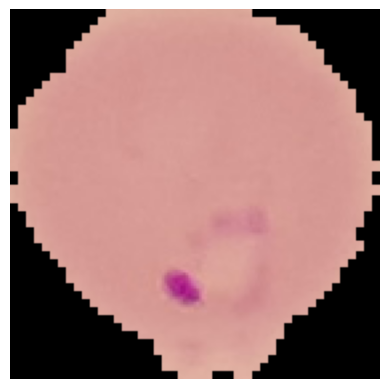

In [19]:
img_show('/content/MalariaDataset/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png')

Uninfected

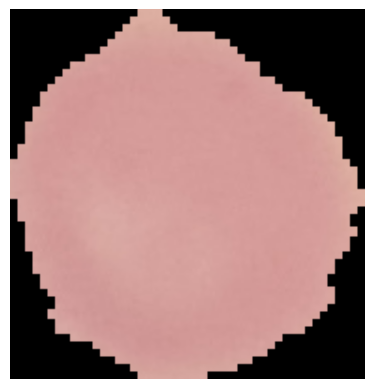

In [20]:
img_show("/content/MalariaDataset/split/test/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_125.png")

In [7]:
import os

def count_images_in_directory(directory):
    image_extensions = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp'}
    count = 0

    for file in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, file)):
            if os.path.splitext(file)[1].lower() in image_extensions:
                count += 1

    return count

# Example usage
directory_path = "/content/MalariaDataset/cell_images/Parasitized"
print("Number of images Parasitized:", count_images_in_directory(directory_path))
print("Number of images Uninfected:", count_images_in_directory("/content/MalariaDataset/cell_images/Uninfected"))
print("Total number of images:", count_images_in_directory(directory_path) + count_images_in_directory("/content/MalariaDataset/cell_images/Uninfected"))


Number of images Parasitized: 13779
Number of images Uninfected: 13779
Total number of images: 27558


## Data preparation

In [13]:
import os
import shutil
import random

# Set paths
original_dir = '/content/MalariaDataset/cell_images'
output_base = '/content/MalariaDataset/split'
splits = {'train': 0.7, 'val': 0.15, 'test': 0.15}  # 70% train, 15% val, 15% test
classes = ['Parasitized', 'Uninfected']

# Ensure output directories exist
for split in splits.keys():
    for cls in classes:
        dir_path = os.path.join(output_base, split, cls)
        os.makedirs(dir_path, exist_ok=True)

# For each class, shuffle and split images, then copy to target folders
for cls in classes:
    src_dir = os.path.join(original_dir, cls)
    images = [f for f in os.listdir(src_dir) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]
    random.shuffle(images)
    n_total = len(images)
    n_train = int(splits['train'] * n_total)
    n_val = int(splits['val'] * n_total)
    n_test = n_total - n_train - n_val

    split_idxs = {
        'train': (0, n_train),
        'val': (n_train, n_train + n_val),
        'test': (n_train + n_val, n_total)
    }

    for split, (start, end) in split_idxs.items():
        split_dir = os.path.join(output_base, split, cls)
        for img in images[start:end]:
            src_path = os.path.join(src_dir, img)
            dst_path = os.path.join(split_dir, img)
            shutil.copy2(src_path, dst_path)

print("Data split complete! The following structure now exists:")
for split in splits.keys():
    for cls in classes:
        folder = os.path.join(output_base, split, cls)
        print(f"{folder}: {len(os.listdir(folder))} images")


Data split complete! The following structure now exists:
/content/MalariaDataset/split/train/Parasitized: 9645 images
/content/MalariaDataset/split/train/Uninfected: 9645 images
/content/MalariaDataset/split/val/Parasitized: 2066 images
/content/MalariaDataset/split/val/Uninfected: 2066 images
/content/MalariaDataset/split/test/Parasitized: 2068 images
/content/MalariaDataset/split/test/Uninfected: 2068 images


In [4]:
import shutil

# Path to the extra unwanted folder
unwanted_folder = '/content/MalariaDataset/cell_images/cell_images'
shutil.rmtree(unwanted_folder)  # This will remove the unwanted subfolder


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil


img_size = (128, 128)
batch_size = 32
data_dir = '/content/MalariaDataset/cell_images'  # Use parent directory!


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


##Model importing

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size+(3,))
base_model.trainable = False  # Freeze the base model layers

# Build the transfer learning model
tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Training model

In [8]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', save_best_only=True)

history = tl_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[es, mc]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8727 - loss: 0.2968

689/689 ━━━━━━━━━━━━━━━━━━━━ 146s 198ms/step - accuracy: 0.8728 - loss: 0.2967 - val_accuracy: 0.9047 - val_loss: 0.2588
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9196 - loss: 0.2153

689/689 ━━━━━━━━━━━━━━━━━━━━ 133s 193ms/step - accuracy: 0.9196 - loss: 0.2153 - val_accuracy: 0.9129 - val_loss: 0.2257
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9226 - loss: 0.2020

689/689 ━━━━━━━━━━━━━━━━━━━━ 130s 189ms/step - accuracy: 0.9226 - loss: 0.2020 - val_accuracy: 0.9194 - val_loss: 0.2142
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - accuracy: 0.9246 - loss: 0.2002 - val_accuracy: 0.9143 - val_loss: 0.2353
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.9283 - loss: 0.1901 - val_accuracy: 0.9181 - val_loss: 0.2265
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 145s 210ms/step - accuracy: 0.9268 - loss: 0.1968 - val_accuracy: 0.9162 - val_loss: 0.2208


##Model Evaluation

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Assuming you have a test dataset generator
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)
preds = tl_model.predict(test_generator)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
print('ROC AUC:', roc_auc_score(y_true, preds))


Found 5510 images belonging to 2 classes.
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2755
           1       0.49      0.48      0.49      2755

    accuracy                           0.49      5510
   macro avg       0.49      0.49      0.49      5510
weighted avg       0.49      0.49      0.49      5510

Confusion Matrix:
 [[1383 1372]
 [1431 1324]]
ROC AUC: 0.495193230588832


In [11]:
print(train_generator.class_indices)


{'Parasitized': 0, 'Uninfected': 1}


#Trying again

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import os

# Paths to your split directories (change if needed)
base_dir = '/content/MalariaDataset/split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
img_size = (128, 128)
batch_size = 32
num_epochs = 25

# 1. Data Generators with augmentation for train, rescale only for val and test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important to preserve order for evaluation
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important to preserve order for evaluation
)

print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# 2. Build MobileNetV2 Transfer Learning Model
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 3. Train the model with EarlyStopping and ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_mobilenetv2.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

# 4. Evaluate on test set
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

roc_auc = roc_auc_score(y_true, preds)
print(f"ROC AUC: {roc_auc:.4f}")


Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
Train samples: 19290
Validation samples: 4132
Test samples: 4136


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8496 - loss: 0.3535

603/603 ━━━━━━━━━━━━━━━━━━━━ 117s 180ms/step - accuracy: 0.8496 - loss: 0.3534 - val_accuracy: 0.9003 - val_loss: 0.2367
Epoch 2/25
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9098 - loss: 0.2345

603/603 ━━━━━━━━━━━━━━━━━━━━ 98s 162ms/step - accuracy: 0.9098 - loss: 0.2345 - val_accuracy: 0.9281 - val_loss: 0.1967
Epoch 3/25
603/603 ━━━━━━━━━━━━━━━━━━━━ 98s 162ms/step - accuracy: 0.9161 - loss: 0.2122 - val_accuracy: 0.9172 - val_loss: 0.2172
Epoch 4/25
603/603 ━━━━━━━━━━━━━━━━━━━━ 96s 160ms/step - accuracy: 0.9218 - loss: 0.2062 - val_accuracy: 0.8976 - val_loss: 0.2598
Epoch 5/25
603/603 ━━━━━━━━━━━━━━━━━━━━ 96s 159ms/step - accuracy: 0.9194 - loss: 0.2146 - val_accuracy: 0.8928 - val_loss: 0.2620
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step
Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.94      0.91      0.92      2068
  Uninfected       0.91      0.94      0.93      2068

    accuracy                           0.93      4136
   macro avg       0.93      0.93      0.93      4136
weighted avg       0.93      0.93      0.93      4136

Confusion Matrix:
[[1880  188]
 [ 117 1951]]
ROC AUC: 0.9773


In [16]:
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
print(confusion_matrix(y_true, y_pred))
print(f"ROC AUC: {roc_auc_score(y_true, preds):.4f}")


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step
              precision    recall  f1-score   support

 Parasitized       0.94      0.91      0.92      2068
  Uninfected       0.91      0.94      0.93      2068

    accuracy                           0.93      4136
   macro avg       0.93      0.93      0.93      4136
weighted avg       0.93      0.93      0.93      4136

[[1880  188]
 [ 117 1951]]
ROC AUC: 0.9773
